In [3]:
%pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os

# --- 1. SETUP ---
# Update this path if your train/val folders are somewhere else (e.g., inside an 'output' folder)
DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset"

BATCH_SIZE = 16  # Reduced to 16 to be safe on memory
NUM_EPOCHS = 10
IMG_SIZE = 224   # EfficientNet-B0 default size
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training on device: {DEVICE}")

# --- 2. DATA PREPARATION ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# This assumes your DATA_DIR has 'train' and 'val' subfolders
# If your folder structure is just class names directly, let me know!
try:
    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
                   for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    print(f"Classes found: {class_names}")
except FileNotFoundError:
    print(f"ERROR: Could not find 'train' or 'val' folders inside {DATA_DIR}")
    print("Please check if you need to run split-folders first.")

# --- 3. MODEL SETUP (EfficientNet-B0) ---
print("Loading EfficientNet-B0...")
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Change the final layer to match your number of classes (e.g., Rice diseases)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(DEVICE)

# --- 4. TRAINING LOOP ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, train_acc_history, val_acc_history

# Start Training
if 'class_names' in locals():
    trained_model, train_hist, val_hist = train_model(model, criterion, optimizer, NUM_EPOCHS)
    
    # Save the model
    torch.save(trained_model.state_dict(), 'efficientnet_b0_final.pth')
    print("Model saved successfully!")

Training on device: cuda
ERROR: Could not find 'train' or 'val' folders inside C:\Users\jeevabharathi\OneDrive\Desktop\Dataset
Please check if you need to run split-folders first.
Loading EfficientNet-B0...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\jeevabharathi/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100.0%


NameError: name 'class_names' is not defined

In [5]:
# 1. Install split-folders if you haven't in this environment
%pip install split-folders

import splitfolders
import os

# 2. Define your input and output paths
input_folder = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset"

# We will create a NEW folder for the split data to avoid messing up the original
output_folder = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet"

# 3. Split the data (80% train, 20% validation)
print("Splitting dataset... this might take a moment.")
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2), group_prefix=None)
print(f"Data split successfully! New dataset path is: {output_folder}")

Note: you may need to restart the kernel to use updated packages.
Splitting dataset... this might take a moment.
Data split successfully! New dataset path is: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os

# --- 1. CONFIGURATION ---
# POINTING TO YOUR NEW SPLIT DATASET
DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet"

BATCH_SIZE = 16
NUM_EPOCHS = 10
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training on: {DEVICE}")

# --- 2. DATA LOADERS ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f"Classes found: {class_names}")

# --- 3. MODEL SETUP ---
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Replace the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(DEVICE)

# --- 4. TRAIN ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, train_acc_history, val_acc_history

# EXECUTE
trained_model, train_hist, val_hist = train_model(model, criterion, optimizer, NUM_EPOCHS)
torch.save(trained_model.state_dict(), 'efficientnet_b0_final.pth')
print("Model Saved!")

Training on: cuda
Classes found: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']

Epoch 1/10
----------
train Loss: 1.0166 Acc: 0.6430
val Loss: 0.8917 Acc: 0.7519

Epoch 2/10
----------
train Loss: 0.5123 Acc: 0.8205
val Loss: 0.5445 Acc: 0.8605

Epoch 3/10
----------
train Loss: 0.3360 Acc: 0.8915
val Loss: 0.3735 Acc: 0.8915

Epoch 4/10
----------
train Loss: 0.2892 Acc: 0.9034
val Loss: 0.4173 Acc: 0.8760

Epoch 5/10
----------
train Loss: 0.2415 Acc: 0.9132
val Loss: 0.5963 Acc: 0.8605

Epoch 6/10
----------
train Loss: 0.1758 Acc: 0.9329
val Loss: 0.4197 Acc: 0.8915

Epoch 7/10
----------
train Loss: 0.1368 Acc: 0.9507
val Loss: 0.3385 Acc: 0.9147

Epoch 8/10
----------
train Loss: 0.0774 Acc: 0.9724
val Loss: 0.3428 Acc: 0.8992

Epoch 9/10
----------
train Loss: 0.0712 Acc: 0.9783
val Loss: 0.2930 Acc: 0.9225

Epoch 10/10
----------
train Loss: 0.0762 Acc: 0.9744
val Loss: 0.8373 Acc: 0.7984

Training complete in 0m 55s
Model Saved!


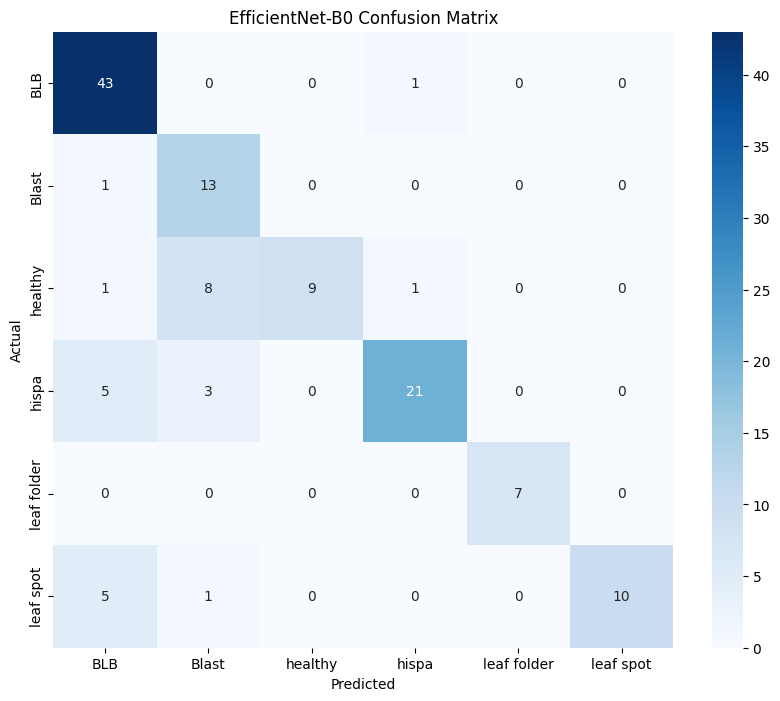

              precision    recall  f1-score   support

         BLB       0.78      0.98      0.87        44
       Blast       0.52      0.93      0.67        14
     healthy       1.00      0.47      0.64        19
       hispa       0.91      0.72      0.81        29
 leaf folder       1.00      1.00      1.00         7
   leaf spot       1.00      0.62      0.77        16

    accuracy                           0.80       129
   macro avg       0.87      0.79      0.79       129
weighted avg       0.85      0.80      0.79       129



In [9]:
# %pip install seaborn scikit-learn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Get Predictions on Validation Data
y_true = []
y_pred = []

trained_model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 2. Create Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('EfficientNet-B0 Confusion Matrix')
plt.show()

# 3. Print Classification Report (Precision, Recall, F1)
print(classification_report(y_true, y_pred, target_names=class_names))

In [10]:
# Install torch-cam for heatmap generation
%pip install torch-cam pillow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch-cam (from versions: none)
ERROR: No matching distribution found for torch-cam


In [11]:
%pip install grad-cam opencv-python

     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
     -- ------------------------------------- 0.5/7.8 MB 429.7 kB/s eta 0:00:17
     -- ------------------------------------- 0.5/7.8 MB 429.7 kB/s eta 0:00:17
     -- ------------------------------------- 0.5/7.8 MB 429.7 kB/s eta 0:00:17
     -- ------------------------------------- 0.5/7.8 MB 429.7 kB/s eta 0:00:17
     -- ------------------------------------- 0.5/7.8 MB 429.7 kB/s eta 0:00:17
     ---- ----------------------------------- 0.8/7.8 MB 342.2 kB/s eta 0:00:21
     ---- ----------------------------------- 0.8/7.8 MB 342.2 kB/s eta 0:00:21
     ----- ---

In [1]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1. Setup Grad-CAM
# We target the last convolutional layer of EfficientNet
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 2. Get a random image from validation set
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)

# Pick the first image in the batch
input_tensor = images[0].unsqueeze(0).to(DEVICE) # Add batch dimension
label_idx = labels[0].item()
true_label = class_names[label_idx]

# 3. Run Prediction
model.eval()
output = model(input_tensor)
probs = torch.nn.functional.softmax(output, dim=1)
conf, pred_idx = torch.max(probs, 1)
pred_label = class_names[pred_idx.item()]
confidence = conf.item() * 100

# 4. Generate Heatmap
# We need to calculate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_idx.item())])
grayscale_cam = grayscale_cam[0, :] # Take first item in batch

# 5. Prepare Image for Display
# We need to reverse the normalization to show the original image cleanly
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Convert tensor to numpy image
img_display = images[0].permute(1, 2, 0).cpu().numpy()
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1) # Ensure values are valid colors

# Overlay Heatmap on Image
visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

# 6. Plot Results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: Original Image
axes[0].imshow(img_display)
axes[0].set_title(f"Input: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", 
                  color=('green' if pred_label == true_label else 'red'), fontsize=14)
axes[0].axis('off')

# Right: Heatmap
axes[1].imshow(visualization)
axes[1].set_title("Grad-CAM Heatmap\n(Where the model is looking)", fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

Classes found: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']
Loading EfficientNet-B0...


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_20276\3887317656.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_b0_f

Success: Loaded 'efficientnet_b0_final.pth'


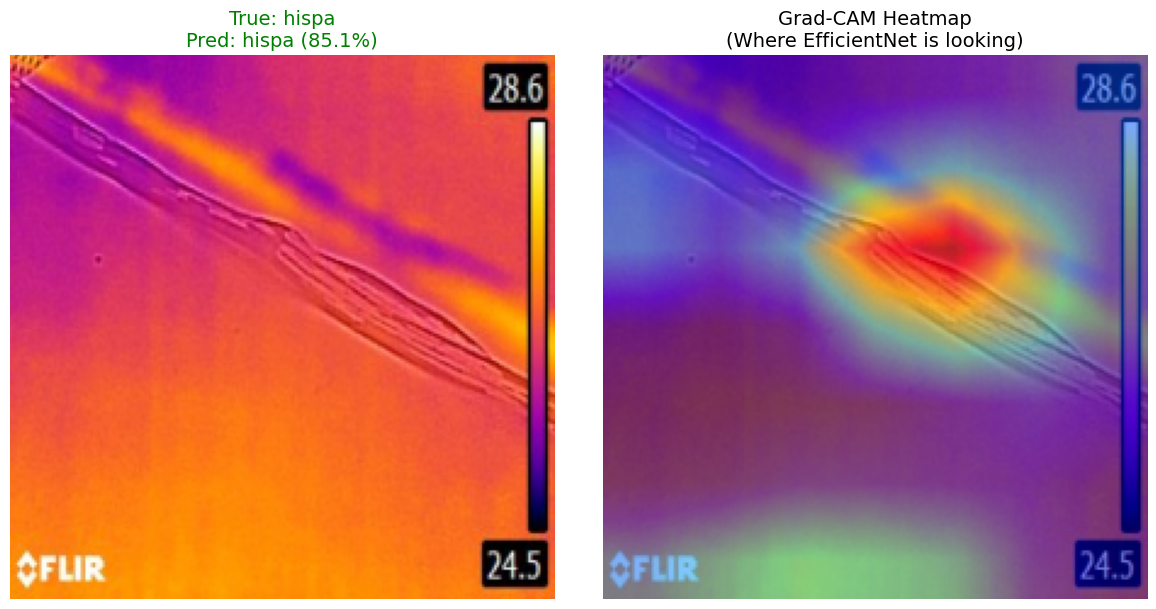

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import os

# ==========================================
# PART 1: SETUP & LOAD SAVED MODEL
# ==========================================

# 1. Configuration
DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Get Class Names (needed to define the model structure)
# We quickly check the dataset folder to know how many classes there are
if os.path.exists(DATA_DIR):
    temp_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'))
    class_names = temp_dataset.classes
    print(f"Classes found: {class_names}")
else:
    # Fallback if folder isn't found (adjust these if needed)
    class_names = ['Blast', 'Blight', 'Brownspot', 'Tungro'] 
    print(f"Warning: Dataset not found. Using fallback classes: {class_names}")

# 3. Load the Model Structure
print("Loading EfficientNet-B0...")
model = models.efficientnet_b0(weights=None) # No weights needed, we load our own
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# 4. Load Your Trained Weights
# This assumes you ran the training code I gave you earlier
try:
    model.load_state_dict(torch.load('efficientnet_b0_final.pth', map_location=DEVICE))
    print("Success: Loaded 'efficientnet_b0_final.pth'")
except FileNotFoundError:
    print("Error: 'efficientnet_b0_final.pth' not found. Please train the model first.")
    
model = model.to(DEVICE)
model.eval()

# ==========================================
# PART 2: GENERATE HEATMAP (Your Requested Code)
# ==========================================

# 1. Setup Grad-CAM
# For EfficientNet, we target the last layer of the 'features' block
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 2. Get a random image from validation set
# We create a temporary loader just to grab one image
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_ds = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), val_transforms)
loader = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=True)

# Extract one image and label
images, labels = next(iter(loader))
input_tensor = images.to(DEVICE)
true_label_idx = labels.item()
true_label = class_names[true_label_idx]

# 3. Run Prediction
output = model(input_tensor)
probs = torch.nn.functional.softmax(output, dim=1)
conf, pred_idx = torch.max(probs, 1)
pred_label = class_names[pred_idx.item()]
confidence = conf.item() * 100

# 4. Generate Heatmap
# Calculate CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_idx.item())])
grayscale_cam = grayscale_cam[0, :] # Take first item in batch

# 5. Prepare Image for Display (Un-normalize)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img_display = images[0].permute(1, 2, 0).cpu().numpy()
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)

# Overlay Heatmap on Image
visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

# 6. Plot Results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: Original Image
axes[0].imshow(img_display)
axes[0].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", 
                  color=('green' if pred_label == true_label else 'red'), fontsize=14)
axes[0].axis('off')

# Right: Heatmap
axes[1].imshow(visualization)
axes[1].set_title("Grad-CAM Heatmap\n(Where EfficientNet is looking)", fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

Preparing Data...
Classes found: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']
Loading EfficientNet-B0...


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_4720\1964213439.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_b0_fi

Success: Loaded 'efficientnet_b0_final.pth'

Calculating Metrics (this may take a moment)...

FINAL RESULTS
              precision    recall  f1-score   support

         BLB       0.78      0.98      0.87        44
       Blast       0.52      0.93      0.67        14
     healthy       1.00      0.47      0.64        19
       hispa       0.91      0.72      0.81        29
 leaf folder       1.00      1.00      1.00         7
   leaf spot       1.00      0.62      0.77        16

    accuracy                           0.80       129
   macro avg       0.87      0.79      0.79       129
weighted avg       0.85      0.80      0.79       129



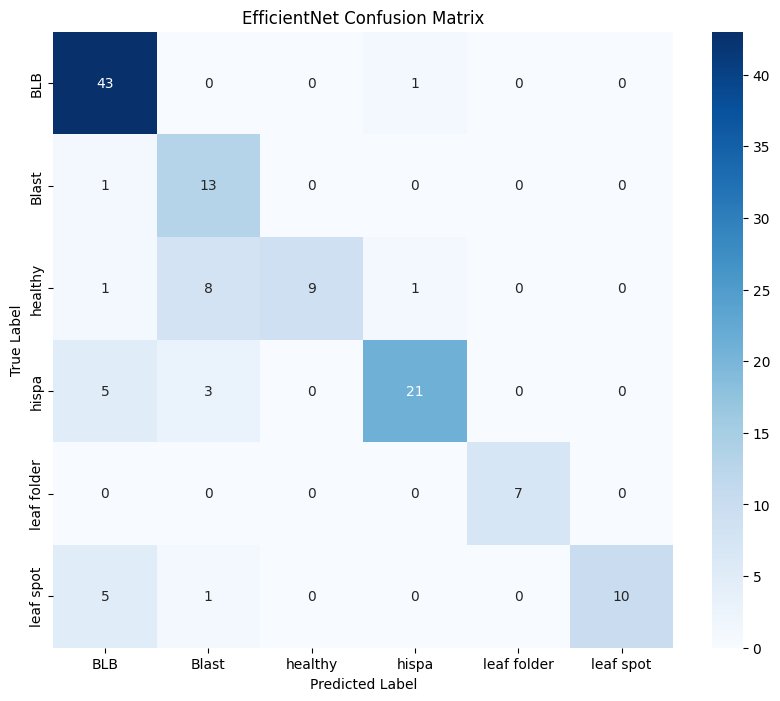

Generating Heatmap for a random test image...


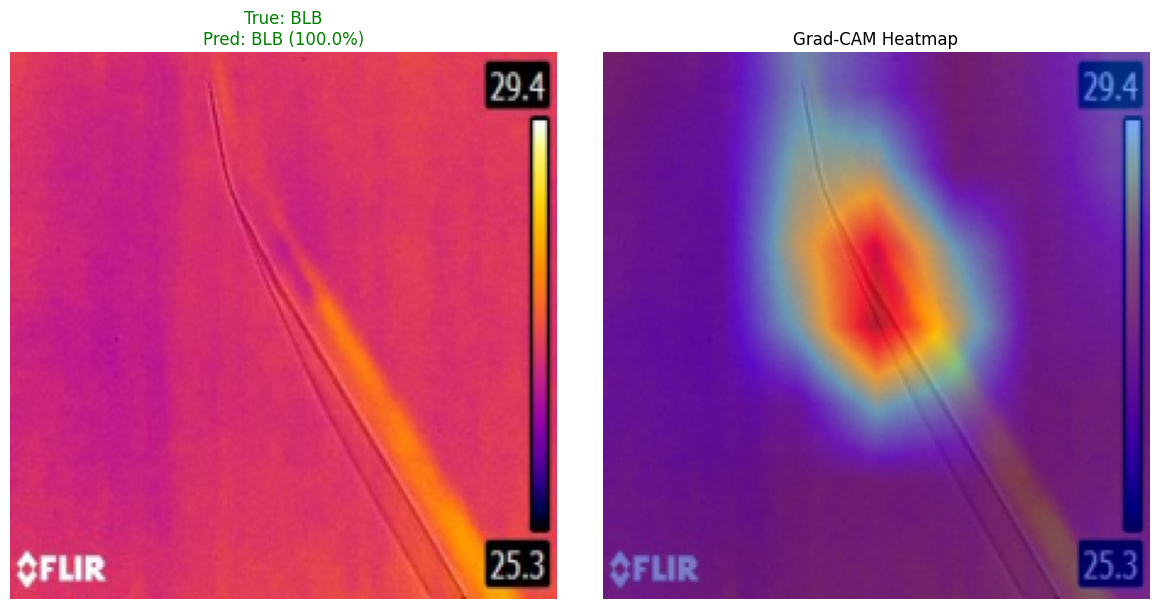

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ==========================================
# PART 1: SETUP & LOAD SAVED MODEL
# ==========================================

DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Prepare Data Loaders
print("Preparing Data...")
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if os.path.exists(DATA_DIR):
    val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), val_transforms)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    class_names = val_dataset.classes
    print(f"Classes found: {class_names}")
else:
    print(f"ERROR: Folder {DATA_DIR} not found.")
    raise FileNotFoundError

# 2. Load Model Architecture & Weights
print("Loading EfficientNet-B0...")
model = models.efficientnet_b0(weights=None) 
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

try:
    model.load_state_dict(torch.load('efficientnet_b0_final.pth', map_location=DEVICE))
    print("Success: Loaded 'efficientnet_b0_final.pth'")
except FileNotFoundError:
    print("Error: Saved model file not found. Please train first.")
    raise

model = model.to(DEVICE)
model.eval()

# ==========================================
# PART 2: CONFUSION MATRIX & F1 SCORE
# ==========================================
print("\nCalculating Metrics (this may take a moment)...")

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Print Classification Report (Precision, Recall, F1-Score)
print("\n" + "="*30)
print("FINAL RESULTS")
print("="*30)
print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('EfficientNet Confusion Matrix')
plt.show()

# ==========================================
# PART 3: GRAD-CAM HEATMAP (VISUALIZATION)
# ==========================================
print("Generating Heatmap for a random test image...")

# Setup Grad-CAM
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Get one random image
temp_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
images, labels = next(iter(temp_loader))
input_tensor = images.to(DEVICE)

# Predict
output = model(input_tensor)
probs = torch.nn.functional.softmax(output, dim=1)
conf, pred_idx = torch.max(probs, 1)
pred_label = class_names[pred_idx.item()]
true_label = class_names[labels.item()]

# Generate Map
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_idx.item())])[0, :]

# Denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = images[0].permute(1, 2, 0).cpu().numpy()
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)

# Plot Side-by-Side
visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_display)
axes[0].set_title(f"True: {true_label}\nPred: {pred_label} ({conf.item()*100:.1f}%)", 
                  color=('green' if pred_label == true_label else 'red'))
axes[0].axis('off')

axes[1].imshow(visualization)
axes[1].set_title("Grad-CAM Heatmap")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Preparing Validation Data...
Classes: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']

Loading EfficientNet-B0 model...


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_4720\211251159.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_loca


Calculating Metrics...

FINAL RESULTS
✅ OVERALL ACCURACY: 79.84%

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         BLB       0.78      0.98      0.87        44
       Blast       0.52      0.93      0.67        14
     healthy       1.00      0.47      0.64        19
       hispa       0.91      0.72      0.81        29
 leaf folder       1.00      1.00      1.00         7
   leaf spot       1.00      0.62      0.77        16

    accuracy                           0.80       129
   macro avg       0.87      0.79      0.79       129
weighted avg       0.85      0.80      0.79       129



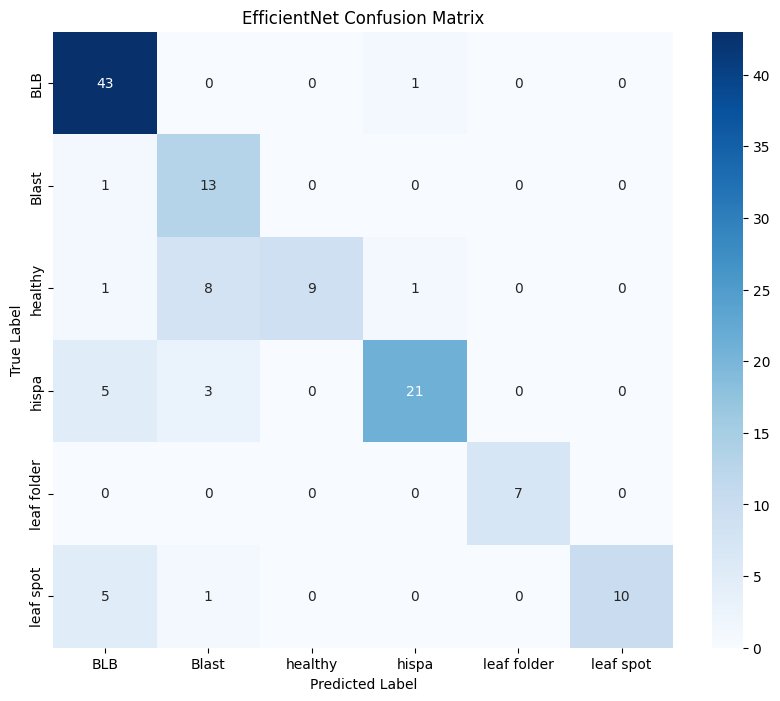


Generating Grad-CAM Heatmap...


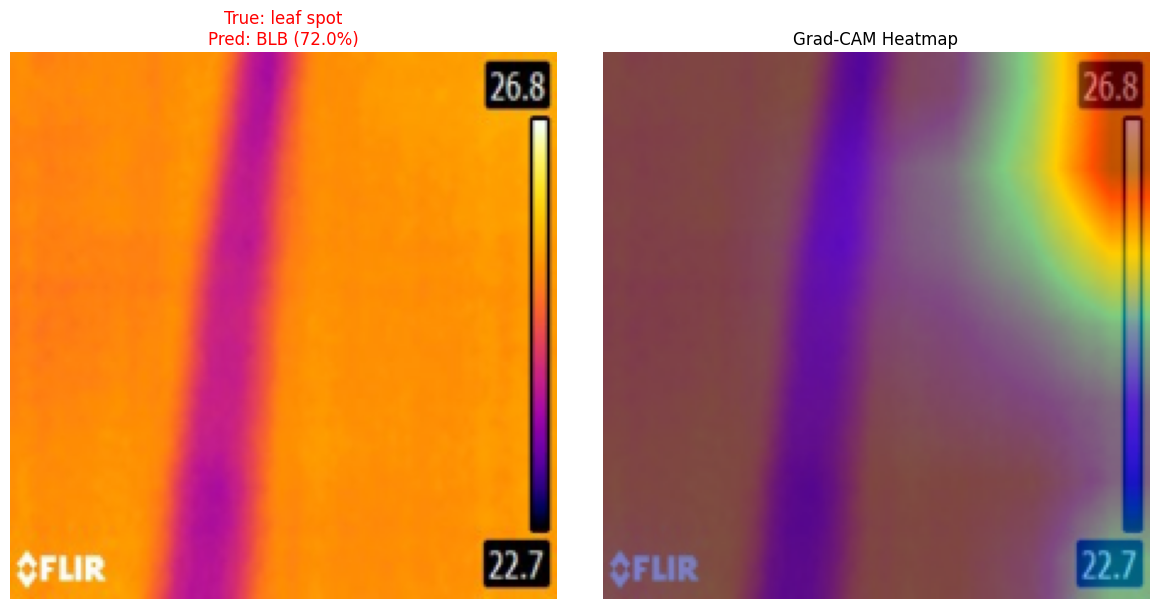

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ==========================================
# PART 1: SETUP & LOAD SAVED MODEL
# ==========================================

DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet"
MODEL_PATH = r"efficientnet_b0_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Data Loader ----------
print("Preparing Validation Data...")

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_path = os.path.join(DATA_DIR, "val")
if not os.path.exists(val_path):
    raise FileNotFoundError(f"Validation folder not found: {val_path}")

val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class_names = val_dataset.classes
print("Classes:", class_names)

# ---------- Load Model ----------
print("\nLoading EfficientNet-B0 model...")

model = models.efficientnet_b0(weights=None)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("Saved model file not found.")

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# Enable gradients for Grad-CAM
for param in model.parameters():
    param.requires_grad = True

# ==========================================
# PART 2: ACCURACY, F1 SCORE & CONFUSION MATRIX
# ==========================================

print("\nCalculating Metrics...")

y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ---------- Overall Accuracy ----------
accuracy = accuracy_score(y_true, y_pred)
print("\n" + "="*40)
print("FINAL RESULTS")
print("="*40)
print(f"✅ OVERALL ACCURACY: {accuracy*100:.2f}%\n")

# ---------- Classification Report ----------
print("📊 CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("EfficientNet Confusion Matrix")
plt.show()

# ==========================================
# PART 3: GRAD-CAM HEATMAP VISUALIZATION
# ==========================================

print("\nGenerating Grad-CAM Heatmap...")

# Grad-CAM setup
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Pick random validation image
sample_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
images, labels = next(iter(sample_loader))
input_tensor = images.to(DEVICE)

# Prediction
outputs = model(input_tensor)
probs = torch.softmax(outputs, dim=1)
conf, pred_idx = torch.max(probs, dim=1)

pred_label = class_names[pred_idx.item()]
true_label = class_names[labels.item()]

# Grad-CAM generation
grayscale_cam = cam(
    input_tensor=input_tensor,
    targets=[ClassifierOutputTarget(pred_idx.item())]
)[0]

# Denormalize image
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img = images[0].permute(1, 2, 0).cpu().numpy()
img = std * img + mean
img = np.clip(img, 0, 1)

# Overlay heatmap
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# ---------- Display ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img)
axes[0].set_title(
    f"True: {true_label}\nPred: {pred_label} ({conf.item()*100:.1f}%)",
    color="green" if pred_label == true_label else "red"
)
axes[0].axis("off")

axes[1].imshow(cam_image)
axes[1].set_title("Grad-CAM Heatmap")
axes[1].axis("off")

plt.tight_layout()
plt.show()
